# Forecasting android app company privacy permissions requests
Michael Steckler, Chelsea Shu, Julian Pelzner, and Ollie Downs 

## Introduction
With the rise of new regulations, such as GDPR, privacy compliance organizations will need to forecast their future workflows. In order to complete and review permissions requests for mobile applications worldwide, privacy compliance organizations will need to hire compliance analysts, which affects their labor expenditures. We want to help these organizations with these forecasting tasks. We decided to focus on android apps in particular.

For some background context, the EU's General Data Protection Regulation (GDPR, implemented 2018) was a major privacy law that was aimed at regulating companies in ways that would protect people’s personal data, and curb some of the behavior of companies that has made the headlines of international news. The spirit of the legislation is rooted in the philosophy that people ought to have the right to control their own data assets. The fallout/aftermath of numerous scandals involving household technology companies, such as Cambridge Analytica, Facebook, the increasing awareness of targeted advertising, as well as the growing occurence of ransomware attacks has been sobering for the citizenry and lawmakers alike. 

With the rise of overarching privacy regulations, such as GDPR, privacy compliance organizations and lawmaking bodies will need to forecast their future workflows. In order to complete and review permissions requests for mobile applications worldwide, these organizations will need to adapt to increased workflows by hiring more compliance analysts. Considering that this could be costly and time-intensive for many organizations, the opportunity to solve vital, time-consuming problems is rich. As such, we have ventured to build privacy management tools and models to help organizations forecast, expedite, and make strategic decisions regarding privacy compliance. Our project could not be more relevant.

Our report focuses on building models related to permissions requests. In a theorized, ideal free market, the private sector and everyday people would come to an equilibrium in terms of the amount and appropriateness of permissions requests. The reality is that most individuals don’t have the time, capacity, or knowledge to understand the content and technical jargon within an app’s Terms and Conditions when they are downloaded onto people’s devices. Moreover, companies have not been fully transparent about how exactly they intend to use the personal data they gather. With GDPR, governments are now responding to this issue with more enhanced scrutiny on how companies can use data collected by permissions requests, especially permissions requests that are regarded as dangerous.

In this report, we compare several machine learning models to address three business goals: 
Predicting the number of total permissions requests post-GDPR, 
Predicting whether an app will request dangerous permissions post-GDPR or not, and 
Predicting the number of dangerous permissions requests post-GDPR.

Predicting the number of post-GDPR permissions requests can enable organizations to forecast the amount of requests their firms will need to process and how long it will take. Predicting whether an app will request dangerous permissions post-GDPR or not is important because it can inform lawmakers to push for stronger legislation on apps in a given country. Moreover, it is important to predict the number of both total and dangerous permissions requests because it can provide insights on how developers are asking for more permissions that needed to operate their apps. This information could be useful to inform future policy. 

In [18]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import urllib.request as urllib2 # For python3

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Data
Our models are trained on data used in an Indiana University School of Informatics, Computing, and Engineering research paper titled “Apps, Code, Culture, and Market Reform: Examining Influences on Android Permissions” (2019). We credit the authors and contributors of this work for graciously allowing us to access this easily workable dataset. This dataset focuses on android apps in particular.

The original paper is included in this GitHub repository.

# Data Cleaning
* First, we imported and merged our two datasets.
* Then, we removed irrelevant columns.
* Then, we add indicator variables for each app's country.
* Then, we add indicator variables for each app's category.
* Then, we used regular expression and iteration to parse the raw text data. This enabled us to dummy code a variable for whether an app has requested permissions that were identified as dangerous in the research paper. We used this code to further count the number of dangerous permissions that were requested.

### Import and merge our two datasets

In [5]:
#import data
pre = pd.read_csv("OLD_permissions_data.csv")
post = pd.read_csv("NEW_permissions_data.csv")

#merge data
gdpr_merge = pre.merge(post, on = ['package_name', 'country'], how = 'inner',  suffixes=('_pre', '_post'))

#view the dataframe
gdpr_merge.head()

,record_num_pre,category_country_num_pre,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,record_num_post,category_country_num_post,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,1,1,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,1,1,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,3,3,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,2,2,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,5,5,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,3,3,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,7,7,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,4,4,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,8,8,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,5,5,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


### Remove irrelevant columns and check for holes in the dataset

In [ ]:
#drop record num and category country number columns
gdpr_merge.drop(["record_num_pre","category_country_num_pre", "record_num_post", "category_country_num_post"],axis = 1, inplace = True)

In [84]:
#dropping rows that have no permissions
lst = list(gdpr_merge[gdpr_merge.permissions_pre == '[]'].index)
gdpr_merge.drop(lst, axis = 0, inplace = True)

In [6]:
#check for null values
gdpr_merge.isnull().sum()

#view the dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


### Adding columns to represent which country the app is from

In [7]:
#dummy code for country

US= []
SK= []
G= []
for i in gdpr_merge['country']:
    if i == 'United States':
        US.append(1)
        SK.append(0)
        G.append(0)
        
    elif i == "South Korea":
        US.append(0)
        SK.append(1)
        G.append(0)
    else:
        US.append(0)
        SK.append(0)
        G.append(1)

In [11]:
#add the 3 new columns into the dataframe and view the dataframe again
gdpr_merge['US'] = US
gdpr_merge['South Korea'] = SK
gdpr_merge['Germany'] = G


#view the new dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post,US,South Korea,Germany
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213,1,0,0


### Adding columns to represent which category the app is in

In [12]:
#see how many unique categories there are
gdpr_merge['category_pre'].unique()

array(['Lifestyle', 'Social', 'Ages 5 & Under'], dtype=object)

In [13]:
#dummy code for category

l= []
a= []
s= []
for i in gdpr_merge['category_pre']:
    if i == 'Lifestyle':
        l.append(1)
        a.append(0)
        s.append(0)
        
    elif i == "Ages 5 & Under":
        a.append(1)
        l.append(0)
        s.append(0)
    else:
        s.append(1)
        a.append(0)
        l.append(0)
        
        
lp= []
ap= []
sp= []
for i in gdpr_merge['category_post']:
    if i == 'Lifestyle':
        lp.append(1)
        ap.append(0)
        sp.append(0)
        
    elif i == "Ages 5 & Under":
        ap.append(1)
        lp.append(0)
        sp.append(0)
    else:
        sp.append(1)
        ap.append(0)
        lp.append(0)

In [14]:
#add the new columns into the dataframe
gdpr_merge['Lifestyle_pre'] = l
gdpr_merge['Ages 5 and Under_pre'] = a
gdpr_merge['Social_pre'] = s

gdpr_merge['Lifestyle_post'] = lp
gdpr_merge['Ages 5 and Under_post'] = ap
gdpr_merge['Social_post'] = sp


#view the new dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,3710134,1,0,0,1,0,0,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,5779024,1,0,0,1,0,0,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,17946632,1,0,0,1,0,0,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,12309718,1,0,0,1,0,0,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,4486213,1,0,0,1,0,0,1,0,0


### Adding indicator and count columns for dangerous permissions

In [15]:
#first, we parse the data
##splitting the permission information into discrete objects
##and removing extraneous quotation marks
## (permission list in raw form was one string)
all_permissions_pre = gdpr_merge['permissions_pre']
lst = []
for i in all_permissions_pre:
    a = i.split("\"")
    for j in a:
        lst.append(j)
gdpr_merge["pre_parsed"] = lst

all_permissions_post = gdpr_merge['permissions_post']
lst2 = []
for i in all_permissions_post:
    a = i.split("\"")
    for j in a:
        lst2.append(j)
gdpr_merge["post_parsed"] = lst2

#view the dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,0,1,0,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,1,0,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '..."


In [19]:
##hard code list of dangerous permissions directly from the paper
dangerous = ["READ_CALENDAR", "WRITE_CALENDAR", "READ_CALL_LOG", 
             "WRITE_CALL_LOG", "PROCESS_OUTGOING_CALLS", "CAMERA",
             "READ_CONTACTS", "WRITE_CONTACTS", "GET_ACCOUNTS", 
             "ACCESS_FINE_LOCATION", "ACCESS_COURSE_LOCATION", 
             "RECORD_AUDIO", "READ_PHONE_STATE", "READ_PHONE_NUMBERS", 
             "CALL_PHONE", "ANSWER_PHONE_CALLS", "ADD_VOICEMAIL", 
             "USE_SIP", "BODY_SENSORS", "SEND_SMS", "RECEIVE_SMS", 
             "READ_SMS", "RECEIVE_WAP_PUSH", "RECEIVE_MMS", 
             "READ_EXTERNAL_STORAGE","WRITE_EXTERNAL_STORAGE"]

dang = []
safe = []
for row in gdpr_merge["pre_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang.append(dangs)
    safe.append(safes)

gdpr_merge["pre_parsed_dangerous"] = dang
gdpr_merge["pre_parsed_safe"] = safe

dang2 = []
safe2 = []
for row in gdpr_merge["post_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang2.append(dangs)
    safe2.append(safes)
gdpr_merge["post_parsed_dangerous"] = dang2
gdpr_merge["post_parsed_safe"] = safe2


#view the dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]"
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]"


In [20]:
#dummy coding for whether an app has pre and post dangerous permissions
dangerous_pre= []
dangerous_post= []

for i in gdpr_merge["pre_parsed_dangerous"]:
    if sum(i) > 0:
        dangerous_pre.append(1)
         
    else:
        dangerous_pre.append(0)
        
for i in gdpr_merge["post_parsed_dangerous"]:
    if sum(i) > 0:
        dangerous_post.append(1)
         
    else:
        dangerous_post.append(0)

gdpr_merge['pre_dangerous'] = dangerous_pre
gdpr_merge['post_dangerous'] = dangerous_post

#view the dataframe
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe,pre_dangerous,post_dangerous
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]",0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...",1,1
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1,1
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]",1,1


In [21]:
## dummy coding for pre and post dangerous permissions counts
dangerous_pre_count= []
dangerous_post_count= []

for i in gdpr_merge["pre_parsed_dangerous"]:
    dangerous_pre_count.append(sum(i))
         
        
for i in gdpr_merge["post_parsed_dangerous"]:
    dangerous_post_count.append(sum(i))
         

gdpr_merge['pre_dangerous_count'] = dangerous_pre_count
gdpr_merge['post_dangerous_count'] = dangerous_post_count


gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe,pre_dangerous,post_dangerous,pre_dangerous_count,post_dangerous_count
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]",0,0,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,4,3
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...",1,1,6,6
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1,1,6,6
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]",1,1,2,2


# EDA

## PERMISSION COUNTS

In [39]:
gdpr_merge.describe().permission_count_pre

count    2804.000000
mean       13.498573
std        15.658948
min         0.000000
25%         6.000000
50%        10.000000
75%        17.000000
max       436.000000
Name: permission_count_pre, dtype: float64

In [56]:
#here we produce an altered dataframe that removes the pre-permission count outlier (436)
no_outlier = gdpr_merge[gdpr_merge['permission_count_pre'] < 200]
no_outlier = no_outlier[no_outlier['permission_count_post'] < 200]

no_outlier.describe()

,google_rank_pre,permission_count_pre,file_size_pre,google_rank_post,permission_count_post,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_dangerous,post_dangerous,pre_dangerous_count,post_dangerous_count
count,2802.000000,2802.000000,2.802000e+03,2802.000000,2802.000000,2.802000e+03,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000
mean,225.327266,13.197002,3.250849e+07,234.295146,14.117416,3.439219e+07,0.324768,0.347966,0.327266,0.344040,0.321913,0.334047,0.343326,0.321913,0.334761,0.865810,0.824768,3.313704,3.360814
std,147.183142,10.854812,4.147440e+07,149.770729,12.143265,4.233223e+07,0.468372,0.476410,0.469299,0.475139,0.467293,0.471740,0.474904,0.467293,0.471991,0.340917,0.380233,2.967590,3.110153
min,1.000000,0.000000,2.442000e+04,0.000000,0.000000,2.442000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.250000,6.000000,8.862291e+06,105.250000,7.000000,9.457959e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,208.000000,10.000000,2.246882e+07,220.000000,11.000000,2.435312e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000
75%,342.000000,17.000000,4.229660e+07,354.000000,18.000000,4.565012e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000
max,540.000000,127.000000,8.398433e+08,539.000000,135.000000,8.398433e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,23.000000


### Distribution of Permission Counts by Category

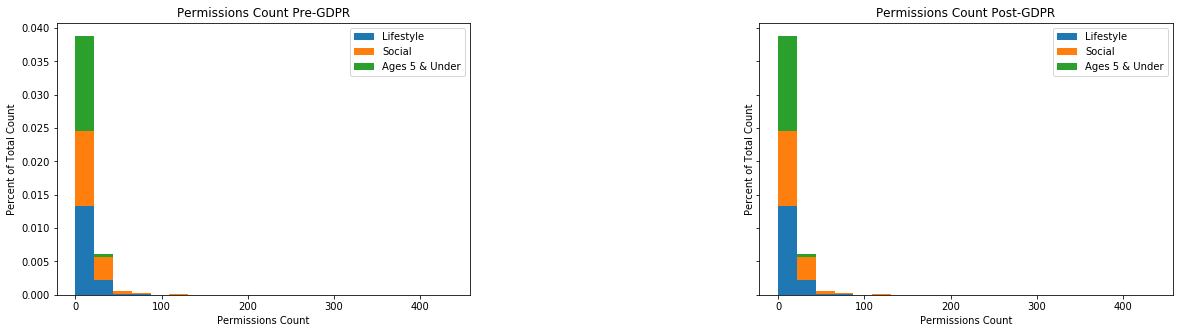

In [54]:
countries = ["US", "South Korea", "Germany"]
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
prerank = gdpr_merge['permission_count_pre']
postrank = gdpr_merge['permission_count_post']
li_pre = prerank.where(gdpr_merge["category_pre"] == "Lifestyle")
so_pre = prerank.where(gdpr_merge["category_pre"] == "Social")
ag_pre = prerank.where(gdpr_merge["category_pre"] == "Ages 5 & Under")
li_post = postrank.where(gdpr_merge["category_post"] == "Lifestyle")
so_post = postrank.where(gdpr_merge["category_post"] == "Social")
ag_post = postrank.where(gdpr_merge["category_post"] == "Ages 5 & Under")
fig, axs = plt.subplots(1,2, figsize = (20,5), sharey = True)
axs = axs.flatten()
axs[0].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Permissions Count')
axs[0].set_ylabel('Percent of Total Count')
axs[0].set_title('Permissions Count Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Permissions Count')
axs[1].set_ylabel('Percent of Total Count')
axs[1].set_title('Permissions Count Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Permission Counts by Category (Without Outlier)

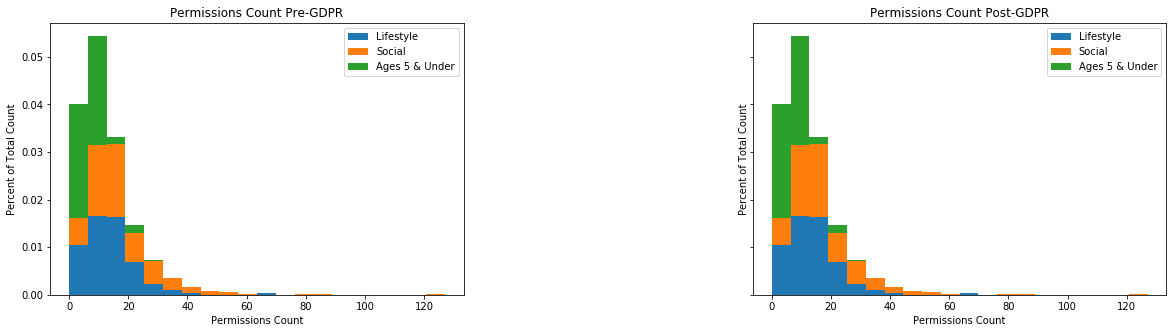

In [55]:
countries = ["US", "South Korea", "Germany"]
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
prerank = no_outlier['permission_count_pre']
postrank = no_outlier['permission_count_post']
li_pre = prerank.where(no_outlier["category_pre"] == "Lifestyle")
so_pre = prerank.where(no_outlier["category_pre"] == "Social")
ag_pre = prerank.where(no_outlier["category_pre"] == "Ages 5 & Under")
li_post = postrank.where(no_outlier["category_post"] == "Lifestyle")
so_post = postrank.where(no_outlier["category_post"] == "Social")
ag_post = postrank.where(no_outlier["category_post"] == "Ages 5 & Under")
fig, axs = plt.subplots(1,2, figsize = (20,5), sharey = True)
axs = axs.flatten()
axs[0].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Permissions Count')
axs[0].set_ylabel('Percent of Total Count')
axs[0].set_title('Permissions Count Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([li_pre, so_pre, ag_pre], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Permissions Count')
axs[1].set_ylabel('Percent of Total Count')
axs[1].set_title('Permissions Count Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

NOTE: <br>
Here, we are just producing a graphic without the outlier to have a clearer view of the distribution. <br>
We still need to explore the outlier to determine whether or not we will omit this datapoint.

### Distribution of Direction of Change in Permission Counts After GDPR

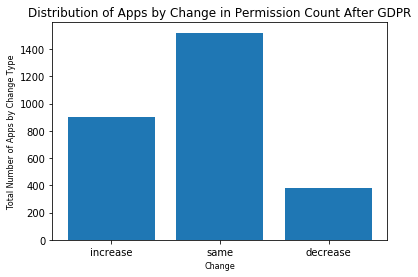

In [57]:
increase_count = gdpr_merge[gdpr_merge['permission_count_post'] > gdpr_merge['permission_count_pre']].shape[0]
same_count = gdpr_merge[gdpr_merge['permission_count_post'] == gdpr_merge['permission_count_pre']].shape[0]
decrease_count = gdpr_merge[gdpr_merge['permission_count_post'] < gdpr_merge['permission_count_pre']].shape[0]

permission_change_counts = [increase_count, same_count, decrease_count]

change_types = ['increase', 'same', 'decrease']
plt.bar(np.arange(len(change_types)), permission_change_counts)
plt.xlabel('Change', fontsize=8)
plt.ylabel('Total Number of Apps by Change Type', fontsize=8)
plt.xticks(np.arange(len(change_types)),change_types, fontsize=10)
plt.title('Distribution of Apps by Change in Permission Count After GDPR')
plt.show()

## DANGEROUS PERMISSIONS

In [76]:
print('Max pre-GDPR dangerous permissions count in dataset:', max(gdpr_merge['pre_dangerous_count'].unique()))
print('Min pre-GDPR dangerous permissions count in dataset:', min(gdpr_merge['pre_dangerous_count'].unique()))

print('Max post-GDPR permissions count in dataset:', max(gdpr_merge['post_dangerous_count'].unique()))
print('Min post-GDPR permissions count in dataset:', min(gdpr_merge['post_dangerous_count'].unique()))

Max pre-GDPR dangerous permissions count in dataset: 23
Min pre-GDPR dangerous permissions count in dataset: 0
Max post-GDPR permissions count in dataset: 23
Min post-GDPR permissions count in dataset: 0


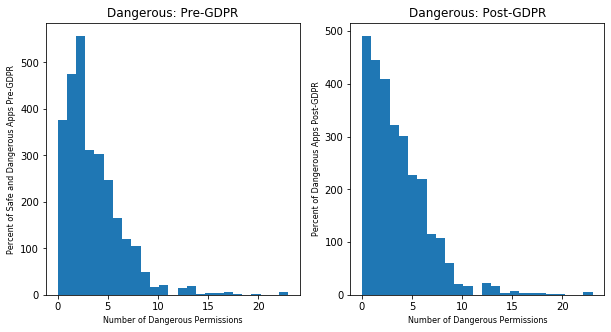

<Figure size 432x288 with 0 Axes>

In [74]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
axs[0].hist(pre, bins=25)
axs[0].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Dangerous: Pre-GDPR')
axs[1].hist(post, bins=25)
axs[1].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Dangerous: Post-GDPR')
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Dangerous Permission Counts by Category

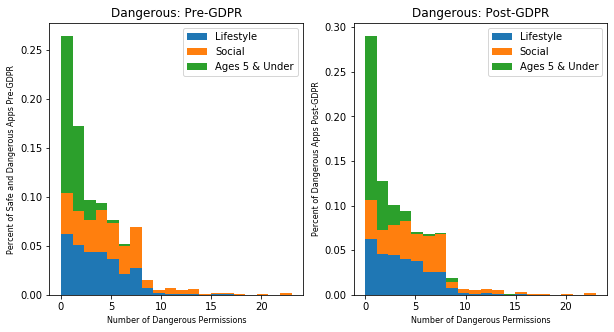

<Figure size 432x288 with 0 Axes>

In [51]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
l_pre = pre.where(gdpr_merge["category_pre"] == "Lifestyle")
s_pre = pre.where(gdpr_merge["category_pre"] == "Social")
a_pre = pre.where(gdpr_merge["category_pre"] == "Ages 5 & Under")
l_post = post.where(gdpr_merge["category_post"] == "Lifestyle")
s_post = post.where(gdpr_merge["category_post"] == "Social")
a_post = post.where(gdpr_merge["category_post"] == "Ages 5 & Under")
axs[0].hist([l_pre, s_pre, a_pre], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Dangerous: Pre-GDPR')
axs[0].legend(["Lifestyle", "Social", "Ages 5 & Under"])
axs[1].hist([l_post, s_post, a_post], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Number of Dangerous Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Dangerous: Post-GDPR')
axs[1].legend(["Lifestyle", "Social", "Ages 5 & Under"])
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Direction of Change in Dangerous Permission Counts After GDPR

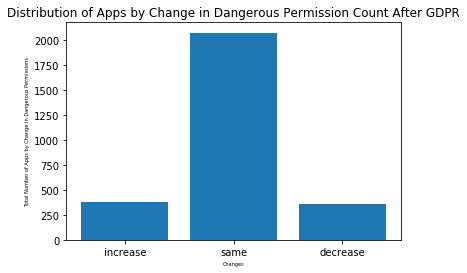

In [59]:
increase_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] > gdpr_merge['pre_dangerous_count']].shape[0]
same_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] == gdpr_merge['pre_dangerous_count']].shape[0]
decrease_dangerous_count = gdpr_merge[gdpr_merge['post_dangerous_count'] < gdpr_merge['pre_dangerous_count']].shape[0]

dangerous_permission_change_counts = [increase_dangerous_count, same_dangerous_count, decrease_dangerous_count]

change_types = ['increase', 'same', 'decrease']
plt.bar(np.arange(len(change_types)), dangerous_permission_change_counts)
plt.xlabel('Changes', fontsize=5)
plt.ylabel('Total Number of Apps by Change in Dangerous Permissions', fontsize=5)
plt.xticks(np.arange(len(change_types)),change_types, fontsize=10)
plt.title('Distribution of Apps by Change in Dangerous Permission Count After GDPR')
plt.show()

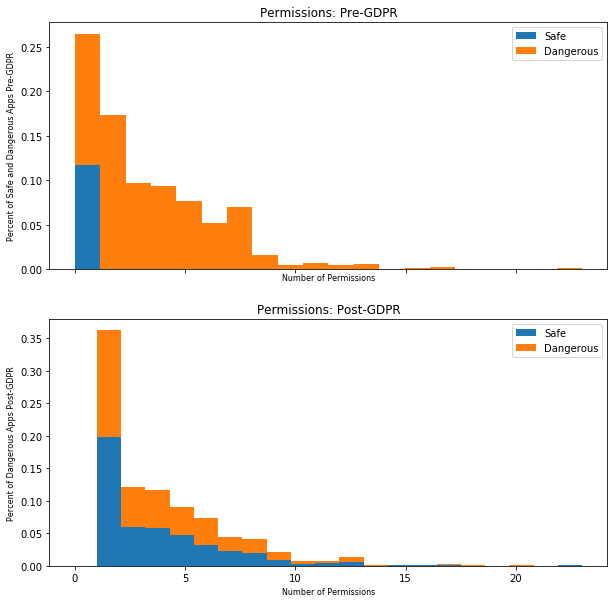

<Figure size 432x288 with 0 Axes>

In [61]:
fig, axs = plt.subplots(2,1, figsize = (10,10), sharex = True)
axs = axs.flatten()
app_safety_type = ['safe','dangerous']
pre = gdpr_merge['pre_dangerous_count']
post = gdpr_merge['post_dangerous_count']
pre_safe = pre.where(gdpr_merge["pre_dangerous"] == 0)
post_safe = post.where(gdpr_merge["post_dangerous"] == 0)
pre_dang = pre.where(gdpr_merge["pre_dangerous"] != 0)
post_dang = post.where(gdpr_merge["post_dangerous"] != 0)
axs[0].hist([pre_safe, pre_dang], bins=20, stacked=True, normed = True)
axs[0].set_xlabel('Number of Permissions', fontsize=8)
axs[0].set_ylabel('Percent of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
axs[0].set_title('Permissions: Pre-GDPR')
axs[0].legend(["Safe", "Dangerous"])
axs[1].hist([pre_dang, post_dang], bins=20, stacked=True, normed = True)
axs[1].set_xlabel('Number of Permissions', fontsize=8)
axs[1].set_ylabel('Percent of Dangerous Apps Post-GDPR', fontsize=8)
axs[1].set_title('Permissions: Post-GDPR')
axs[1].legend(["Safe", "Dangerous"])
plt.show()
plt.subplots_adjust(wspace = 0.7, hspace = 0.7)

### Distribution of Apps by Whether They Contain Dangerous Permissions Pre-GDPR

[376, 2428]


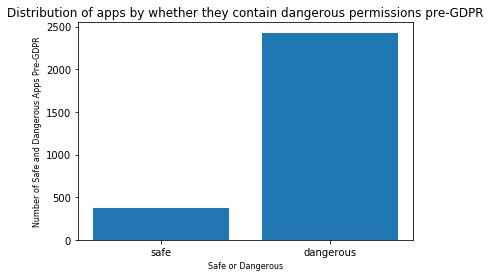

In [67]:
safe_apps_count_pre = 0
dangerous_apps_count_pre = 0
for i in gdpr_merge['pre_dangerous']:
    if i==0:
        safe_apps_count_pre += 1
    if i==1:
        dangerous_apps_count_pre += 1

app_safety_count_pre = [safe_apps_count_pre, dangerous_apps_count_pre]
print(app_safety_count_pre)

app_safety_type = ['safe','dangerous']
plt.bar(np.arange(len(app_safety_type)), app_safety_count_pre)
plt.xlabel('Safe or Dangerous', fontsize=8)
plt.ylabel('Number of Safe and Dangerous Apps Pre-GDPR', fontsize=8)
plt.xticks(np.arange(len(app_safety_type)),app_safety_type, fontsize=10)
plt.title('Distribution of apps by whether they contain dangerous permissions pre-GDPR')
plt.show()

### Distribution of Apps by Whether They Contain Dangerous Permissions Post-GDPR

[491, 2313]


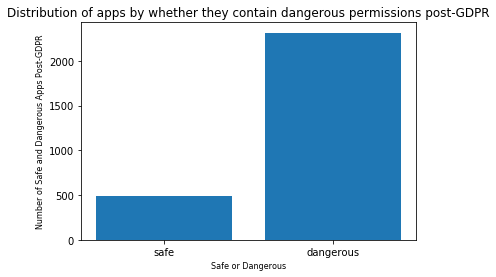

In [65]:
safe_apps_count_post = 0
dangerous_apps_count_post = 0
for i in gdpr_merge['post_dangerous']:
    if i==0:
        safe_apps_count_post += 1
    if i==1:
        dangerous_apps_count_post += 1

app_safety_count_post = [safe_apps_count_post, dangerous_apps_count_post]
print(app_safety_count_post)

app_safety_type = ['safe','dangerous']
plt.bar(np.arange(len(app_safety_type)), app_safety_count_post)
plt.xlabel('Safe or Dangerous', fontsize=8)
plt.ylabel('Number of Safe and Dangerous Apps Post-GDPR', fontsize=8)
plt.xticks(np.arange(len(app_safety_type)),app_safety_type, fontsize=10)
plt.title('Distribution of apps by whether they contain dangerous permissions post-GDPR')
plt.show()

In [47]:
#big correlation matrix
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = gdpr_merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,google_rank_pre,permission_count_pre,file_size_pre,google_rank_post,permission_count_post,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_dangerous,post_dangerous,pre_dangerous_count,post_dangerous_count
google_rank_pre,1,-0.0891142,-0.100888,0.713649,-0.0890263,-0.102538,-0.017584,-0.0131129,0.0308692,-0.000399116,-0.0092566,0.00956615,-0.000257436,-0.0092566,0.00941842,-0.132393,-0.0968419,-0.143607,-0.137679
permission_count_pre,-0.0891142,1,-0.0484954,-0.106811,0.958418,-0.0349214,0.00942613,0.0587407,-0.0690562,0.00735568,-0.264633,0.254591,0.00644752,-0.264633,0.255373,0.209804,0.216716,0.671815,0.644209
file_size_pre,-0.100888,-0.0484954,1,-0.105484,-0.0579983,0.964234,0.0531336,-0.0792373,0.0274148,-0.218226,0.446201,-0.222072,-0.217892,0.446201,-0.222399,0.0486473,-0.00249297,-0.090176,-0.0914514
google_rank_post,0.713649,-0.106811,-0.105484,1,-0.108037,-0.104139,-0.0102053,-0.00449145,0.0147486,-0.0526959,0.0368131,0.0166014,-0.0510876,0.0368131,0.014949,-0.109653,-0.0398251,-0.156549,-0.1401
permission_count_post,-0.0890263,0.958418,-0.0579983,-0.108037,1,-0.0267672,0.00983726,0.0503113,-0.0609073,0.0135465,-0.272106,0.255758,0.0130921,-0.272106,0.256087,0.187559,0.243259,0.657982,0.677339
file_size_post,-0.102538,-0.0349214,0.964234,-0.104139,-0.0267672,1,0.0545403,-0.0772238,0.0239661,-0.222567,0.430642,-0.202299,-0.222807,0.430642,-0.202061,0.0536723,0.0201892,-0.064591,-0.0494124
US,-0.017584,0.00942613,0.0531336,-0.0102053,0.00983726,0.0545403,1,-0.506898,-0.483596,-0.0147447,0.0145844,0.00040406,-0.0169178,0.0145844,0.00258185,0.0115307,0.037112,0.00415185,0.00278698
South Korea,-0.0131129,0.0587407,-0.0792373,-0.00449145,0.0503113,-0.0772238,-0.506898,1,-0.509373,0.0212104,-0.0287894,0.00715055,0.0207418,-0.0287894,0.00762865,0.0568515,-0.00412801,0.120822,0.113324
Germany,0.0308692,-0.0690562,0.0274148,0.0147486,-0.0609073,0.0239661,-0.483596,-0.509373,1,-0.0068176,0.0146735,-0.00766413,-0.00417231,0.0146735,-0.0103237,-0.0692389,-0.0328575,-0.126829,-0.117853
Lifestyle_pre,-0.000399116,0.00735568,-0.218226,-0.0526959,0.0135465,-0.222567,-0.0147447,0.0212104,-0.0068176,1,-0.498457,-0.513186,0.996838,-0.498457,-0.509237,0.0887277,0.143831,0.0897499,0.0899552


#